In [1]:
# Core
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd

# Request the description of each col
from projeto1bi.utils import dic_cols

# Viz (quick EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: data prep, CV, metrics, baseline models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, mean_absolute_error, mean_squared_error
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Quality of life
import warnings; warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)

In [2]:
from pathlib import Path

folder_dir = "data"

base_path = Path.cwd().parent / folder_dir
dim_teachers =  pd.read_csv(base_path / "dim_teachers.csv")
fct_interaction = pd.read_csv(base_path / "fct_teachers_contents_interactions.csv")
fct_entries = pd.read_csv(base_path / "fct_teachers_entries.csv")
dictionary = pd.read_csv(base_path / "aprendizap_dictionary.csv")

In [3]:
fct_entries["data_inicio"] = pd.to_datetime(fct_entries["data_inicio"], errors="coerce")
fct_entries["data_fim"] = pd.to_datetime(fct_entries["data_fim"], errors="coerce")
fct_interaction["data_inicio"] = pd.to_datetime(fct_interaction["data_inicio"], errors="coerce")

fct_entries["tempo_sessao"] = fct_entries["data_fim"] - fct_entries["data_inicio"]
fct_entries["tempo_sessao"] = fct_entries["tempo_sessao"].dt.total_seconds() / 60

In [4]:
fct_interaction.head()

,unique_id,user_type,user_agent_device_type,data_inicio,event_type,content_type,id_aula,utm_source
0,599e78c8-a3ed-4a43-bf99-9ceb012079e4,registered,NaN,2024-05-19 18:26:22.525,criacao_turma_relatorio,relatorio,NaN,NaN
1,794850fa-e0a3-4bdb-821a-32fb8657e981,registered,NaN,2024-02-07 22:37:41.864,criacao_anotacao_relatorio,relatorio,NaN,NaN
2,b507b6b4-21c3-4f93-9126-7341040579aa,registered,NaN,2024-03-27 06:53:24.246,criacao_anotacao_relatorio,relatorio,NaN,NaN
3,707c5747-f213-402f-896b-f8129fe36910,registered,NaN,2024-04-01 17:23:51.336,criacao_anotacao_relatorio,relatorio,NaN,NaN
4,707c5747-f213-402f-896b-f8129fe36910,registered,NaN,2024-04-02 11:41:33.447,criacao_anotacao_relatorio,relatorio,NaN,NaN


In [5]:
fct_entries.head()

,unique_id,user_type,data_inicio,data_fim,tempo_sessao
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,seo,2022-12-12 15:35:03.601,2022-12-12 15:35:36.305,0.545067
1,463135f9-2345-4b25-845f-bc52f6e41362,seo,2023-04-11 08:55:55.225,2023-04-11 08:56:56.637,1.023533
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,seo,2023-03-30 12:27:39.857,2023-03-30 12:27:40.077,0.003667
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,seo,2023-06-06 22:20:14.298,2023-06-06 22:20:14.629,0.005517
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,seo,2023-05-29 19:26:15.913,2023-05-29 19:26:16.139,0.003767


In [6]:
import pandas as pd

# Documentação:
# O objetivo é criar duas novas colunas no dataframe 'fct_entries'
# a partir da coluna de timestamp 'data_inicio'.

# --- 1. EXTRAINDO O DIA DA SEMANA ---

# Criamos um mapa para traduzir o número do dia da semana (onde Segunda=0, Domingo=6)
# para as abreviações em português que você pediu.
mapa_dia_semana = {
    0: 'seg',
    1: 'ter',
    2: 'qua',
    3: 'qui',
    4: 'sex',
    5: 'sab',
    6: 'dom'
}

# Usamos o acessor .dt.weekday para obter o número do dia e .map() para aplicar nossa tradução.
fct_entries['dia_semana'] = fct_entries['data_inicio'].dt.weekday.map(mapa_dia_semana)
print("Coluna 'dia_semana' criada com sucesso.")


# --- 2. EXTRAINDO O PERÍODO DO DIA ---

# Definimos os limites e os nomes para cada período do dia.
# Madrugada: 0h-5h | Manhã: 6h-11h | Tarde: 12h-17h | Noite: 18h-23h
bins = [-1, 5, 11, 17, 23]
labels = ['madrugada', 'manha', 'tarde', 'noite']

# Usamos o acessor .dt.hour para extrair a hora e a função pd.cut para categorizar em períodos.
# pd.cut é uma forma muito eficiente de criar categorias a partir de valores numéricos.
fct_entries['periodo_dia'] = pd.cut(fct_entries['data_inicio'].dt.hour, bins=bins, labels=labels, right=True)
print("Coluna 'periodo_dia' criada com sucesso.")


# --- 3. VERIFICAÇÃO ---
# Mostramos as 5 primeiras linhas com as novas colunas para verificação.
print("\n--- Amostra do resultado ---")
print(fct_entries[['data_inicio', 'dia_semana', 'periodo_dia']].head())

# Mostramos a contagem de entradas por período para análise.
print("\n--- Distribuição por Período do Dia ---")
print(fct_entries['periodo_dia'].value_counts())

print("\n--- Distribuição por Dia da Semana ---")
print(fct_entries['dia_semana'].value_counts())

Coluna 'dia_semana' criada com sucesso.
Coluna 'periodo_dia' criada com sucesso.

--- Amostra do resultado ---
              data_inicio dia_semana periodo_dia
0 2022-12-12 15:35:03.601        seg       tarde
1 2023-04-11 08:55:55.225        ter       manha
2 2023-03-30 12:27:39.857        qui       tarde
3 2023-06-06 22:20:14.298        ter       noite
4 2023-05-29 19:26:15.913        seg       noite

--- Distribuição por Período do Dia ---
periodo_dia
tarde        919640
manha        852538
noite        565956
madrugada    107916
Name: count, dtype: int64

--- Distribuição por Dia da Semana ---
dia_semana
seg    462201
ter    411911
qua    401060
qui    380485
sex    297310
dom    294373
sab    198710
Name: count, dtype: int64


In [7]:
fct_interaction.head()

,unique_id,user_type,user_agent_device_type,data_inicio,event_type,content_type,id_aula,utm_source
0,599e78c8-a3ed-4a43-bf99-9ceb012079e4,registered,NaN,2024-05-19 18:26:22.525,criacao_turma_relatorio,relatorio,NaN,NaN
1,794850fa-e0a3-4bdb-821a-32fb8657e981,registered,NaN,2024-02-07 22:37:41.864,criacao_anotacao_relatorio,relatorio,NaN,NaN
2,b507b6b4-21c3-4f93-9126-7341040579aa,registered,NaN,2024-03-27 06:53:24.246,criacao_anotacao_relatorio,relatorio,NaN,NaN
3,707c5747-f213-402f-896b-f8129fe36910,registered,NaN,2024-04-01 17:23:51.336,criacao_anotacao_relatorio,relatorio,NaN,NaN
4,707c5747-f213-402f-896b-f8129fe36910,registered,NaN,2024-04-02 11:41:33.447,criacao_anotacao_relatorio,relatorio,NaN,NaN


In [8]:
elementos = [fct_interaction['event_type'].unique(),fct_interaction['content_type'].unique(),fct_interaction['id_aula'].unique(),fct_interaction['utm_source'].unique()]

for elemento in elementos:
    print
    print(elemento)

['criacao_turma_relatorio' 'criacao_anotacao_relatorio'
 'visualizacao_aula' 'visualizacao_metodologia_ativa' 'download_aula' nan
 'compartilhamento_direto' 'visualizacao_avaliacao'
 'botao_criar_plano_aula' 'download_avaliacao' 'visualizacao_conteudo_ia'
 'download_plano_aula' 'visualizacao_prova' 'visualizacao_plano_aula'
 'criacao_plano_aula' 'envio_email_ou_baixou_prova' 'rascunho_plano_aula'
 'botao_criar_plano_sem_aula' 'download_conteudo_ia'
 'fechar_conquista_obtida' 'rascunho_prova' 'prova_salva'
 'acesso_aba_conquistas' 'acesso_comunidade' 'click_subaba_disponiveis'
 'click_subaba_concluidas' 'click_link_missao_aulas'
 'click_link_missao_relatorio_turma' 'botao_baixar_conquista_modal'
 'botao_compartilhar_conquista_modal' 'click_selo_conquista'
 'botao_baixar_conquista_completada' 'click_link_missao_plano_de_aula'
 'botao_compartilhar_conquista_completada' 'click_link_missao_mari'
 'click_link_missao_blog' 'click_link_missao_comunidade']
['relatorio' nan 'pagina_metodologia_a

In [9]:
import pandas as pd

# Documentação:
# O objetivo é criar um dataframe que, para cada par (unique_id, dia) presente em fct_entries,
# mostre o número total de interações daquele unique_id naquele dia, contado a partir de fct_interaction.

# --- 1. PREPARAÇÃO DOS DATAFRAMES ---

# Garantir que as colunas de data em ambas as tabelas estão no formato datetime
print("Preparando as colunas de data...")
fct_entries['data_inicio'] = pd.to_datetime(fct_entries['data_inicio'])
fct_interaction['data_inicio'] = pd.to_datetime(fct_interaction['data_inicio'])

# Extrair a data (sem a hora) em ambas as tabelas para criar uma chave comum
fct_entries['data'] = fct_entries['data_inicio'].dt.date
fct_interaction['data'] = fct_interaction['data_inicio'].dt.date
print("Colunas 'data' criadas com sucesso.")


# --- 2. CRIAR A BASE DE "PROFESSOR-DIA" A PARTIR DE FCT_ENTRIES ---

# Selecionamos os pares únicos de (unique_id, data) de fct_entries.
# Esta é a nossa lista de "dias ativos" para cada professor.
print("\nIdentificando dias com sessões ativas por professor...")
dias_com_sessao = fct_entries[['unique_id', 'data']].drop_duplicates().reset_index(drop=True)
print(f"Encontrados {len(dias_com_sessao)} pares únicos de 'professor-dia' em fct_entries.")


# --- 3. CALCULAR CONTAGEM DE INTERAÇÕES A PARTIR DE FCT_INTERACTION ---

# Calculamos o número de interações por professor e por dia.
print("\nCalculando o número de interações por dia em fct_interaction...")
contagem_interacoes = fct_interaction.groupby(['unique_id', 'data']).size().reset_index(name='numero_interacoes')
print("Contagem de interações concluída.")


# --- 4. UNIFICAR OS RESULTADOS ---

# Unimos nossa base de 'dias_com_sessao' com a 'contagem_interacoes'.
# Usamos um 'left merge' para garantir que manteremos todos os dias em que houve sessão.
print("\nUnificando os resultados...")
resultado_final = pd.merge(
    dias_com_sessao,
    contagem_interacoes,
    on=['unique_id', 'data'],
    how='left'
)

# Se um dia teve sessão mas nenhuma interação, o resultado do merge será NaN.
# Preenchemos esses casos com 0, pois significa 0 interações.
resultado_final['numero_interacoes'].fillna(0, inplace=True)
resultado_final['numero_interacoes'] = resultado_final['numero_interacoes'].astype(int)
print("Unificação e limpeza concluídas.")


# --- 5. VERIFICAÇÃO ---
print("\n--- Amostra do Resultado Final ---")
print(resultado_final.head(10))
print(f"\nO dataframe final 'resultado_final' foi criado com {resultado_final.shape[0]} linhas.")

Preparando as colunas de data...
Colunas 'data' criadas com sucesso.

Identificando dias com sessões ativas por professor...
Encontrados 1874162 pares únicos de 'professor-dia' em fct_entries.

Calculando o número de interações por dia em fct_interaction...
Contagem de interações concluída.

Unificando os resultados...
Unificação e limpeza concluídas.

--- Amostra do Resultado Final ---
                              unique_id        data  numero_interacoes
0  648c29c1-5c68-4308-bc40-f85a4ab760f8  2022-12-12                  1
1  463135f9-2345-4b25-845f-bc52f6e41362  2023-04-11                  5
2  0bb96cab-5bd6-4e80-beff-9bb58590b0cb  2023-03-30                  1
3  6d38f15b-a76d-4b92-bddb-1d6e4ec4deec  2023-06-06                  1
4  4c3edd9b-2f40-491f-9e88-5e8bf90accbb  2023-05-29                  1
5  8e6f9ebc-41b4-4bf6-9fda-a3716d30a34d  2023-05-15                  0
6  d87c6e65-8f5a-48b1-905c-1a6dbf454532  2023-07-04                  1
7  e84c023b-df1e-48e0-9016-22d04cd0d5ab  2

In [10]:
resultado_final.head()

,unique_id,data,numero_interacoes
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,2022-12-12,1
1,463135f9-2345-4b25-845f-bc52f6e41362,2023-04-11,5
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,2023-03-30,1
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,2023-06-06,1
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,2023-05-29,1


In [11]:
# Documentação:
# O objetivo é unificar o dataframe 'fct_entries' com o 'resultado_final'.
# Isso irá adicionar a coluna 'numero_interacoes' a cada linha de 'fct_entries',
# com base na correspondência de 'unique_id' e 'data'.

print("Iniciando a unificação de 'fct_entries' com 'resultado_final'...")

# Usamos um 'left merge' para garantir que todas as linhas (sessões) de fct_entries sejam mantidas.
# A chave da unificação são as colunas 'unique_id' e 'data'.
df_unificado_final = pd.merge(
    fct_entries,
    resultado_final,
    on=['unique_id', 'data'],
    how='left'
)

# O merge deve ser limpo, mas por segurança, vamos verificar se algum NaN foi criado.
# Isso poderia acontecer se, por alguma razão, um par (unique_id, data) em fct_entries
# não estivesse em resultado_final. Preenchemos com 0.
df_unificado_final['numero_interacoes'].fillna(0, inplace=True)
df_unificado_final['numero_interacoes'] = df_unificado_final['numero_interacoes'].astype(int)


print("Unificação concluída com sucesso.")


# --- VERIFICAÇÃO ---
# Mostramos o resultado, selecionando colunas chave para confirmar que a unificação funcionou.
print("\n--- Amostra do DataFrame Unificado Final ---")
colunas_para_verificar = [
    'unique_id',
    'data_inicio',      # A data/hora original da sessão
    'tempo_sessao',       # O tempo da sessão específica
    'data',             # A data que usamos como chave
    'numero_interacoes' # O número total de interações naquele dia
]
print(df_unificado_final[colunas_para_verificar].head())

print(f"\nO dataframe final 'df_unificado_final' tem {df_unificado_final.shape[0]} linhas.")

Iniciando a unificação de 'fct_entries' com 'resultado_final'...
Unificação concluída com sucesso.

--- Amostra do DataFrame Unificado Final ---
                              unique_id  ... numero_interacoes
0  648c29c1-5c68-4308-bc40-f85a4ab760f8  ...                 1
1  463135f9-2345-4b25-845f-bc52f6e41362  ...                 5
2  0bb96cab-5bd6-4e80-beff-9bb58590b0cb  ...                 1
3  6d38f15b-a76d-4b92-bddb-1d6e4ec4deec  ...                 1
4  4c3edd9b-2f40-491f-9e88-5e8bf90accbb  ...                 1

[5 rows x 5 columns]

O dataframe final 'df_unificado_final' tem 2446050 linhas.


In [12]:
df_unificado_final.head()

,unique_id,user_type,data_inicio,data_fim,tempo_sessao,dia_semana,periodo_dia,data,numero_interacoes
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,seo,2022-12-12 15:35:03.601,2022-12-12 15:35:36.305,0.545067,seg,tarde,2022-12-12,1
1,463135f9-2345-4b25-845f-bc52f6e41362,seo,2023-04-11 08:55:55.225,2023-04-11 08:56:56.637,1.023533,ter,manha,2023-04-11,5
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,seo,2023-03-30 12:27:39.857,2023-03-30 12:27:40.077,0.003667,qui,tarde,2023-03-30,1
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,seo,2023-06-06 22:20:14.298,2023-06-06 22:20:14.629,0.005517,ter,noite,2023-06-06,1
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,seo,2023-05-29 19:26:15.913,2023-05-29 19:26:16.139,0.003767,seg,noite,2023-05-29,1


In [13]:


# Documentação:
# O objetivo é criar duas novas colunas, 'ano' e 'mes',
# a partir da coluna 'data_inicio' do dataframe 'df_unificado_final'.

print("Adicionando colunas de ano e mês...")

# --- 1. PREPARAÇÃO (SEGURANÇA) ---
# Garantimos que a coluna 'data_inicio' está no formato datetime.
df_unificado_final['data_inicio'] = pd.to_datetime(df_unificado_final['data_inicio'])


# --- 2. CRIAÇÃO DAS COLUNAS ---
# Usamos o acessor .dt para extrair o ano (.dt.year) e o mês (.dt.month).
df_unificado_final['ano'] = df_unificado_final['data_inicio'].dt.year
df_unificado_final['mes'] = df_unificado_final['data_inicio'].dt.month

print("Colunas 'ano' e 'mes' criadas com sucesso.")


# --- 3. VERIFICAÇÃO ---
# Mostramos as 5 primeiras linhas com a data original e as novas colunas para verificação.
print("\n--- Amostra do resultado ---")
print(df_unificado_final[['data_inicio', 'ano', 'mes']].head())

# Mostramos a contagem de entradas por ano e mês para uma análise rápida.
print("\n--- Distribuição por Ano ---")
print(df_unificado_final['ano'].value_counts().sort_index())

print("\n--- Distribuição por Mês ---")
print(df_unificado_final['mes'].value_counts().sort_index())

Adicionando colunas de ano e mês...
Colunas 'ano' e 'mes' criadas com sucesso.

--- Amostra do resultado ---
              data_inicio   ano  mes
0 2022-12-12 15:35:03.601  2022   12
1 2023-04-11 08:55:55.225  2023    4
2 2023-03-30 12:27:39.857  2023    3
3 2023-06-06 22:20:14.298  2023    6
4 2023-05-29 19:26:15.913  2023    5

--- Distribuição por Ano ---
ano
2022    385666
2023    822884
2024    945757
2025    291743
Name: count, dtype: int64

--- Distribuição por Mês ---
mes
1      83533
2     191292
3     278693
4     260688
5     246063
6     235355
7     192038
8     247777
9     224490
10    202013
11    193131
12     90977
Name: count, dtype: int64


In [14]:
df_unificado_final.head()

,unique_id,user_type,data_inicio,data_fim,tempo_sessao,dia_semana,periodo_dia,data,numero_interacoes,ano,mes
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,seo,2022-12-12 15:35:03.601,2022-12-12 15:35:36.305,0.545067,seg,tarde,2022-12-12,1,2022,12
1,463135f9-2345-4b25-845f-bc52f6e41362,seo,2023-04-11 08:55:55.225,2023-04-11 08:56:56.637,1.023533,ter,manha,2023-04-11,5,2023,4
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,seo,2023-03-30 12:27:39.857,2023-03-30 12:27:40.077,0.003667,qui,tarde,2023-03-30,1,2023,3
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,seo,2023-06-06 22:20:14.298,2023-06-06 22:20:14.629,0.005517,ter,noite,2023-06-06,1,2023,6
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,seo,2023-05-29 19:26:15.913,2023-05-29 19:26:16.139,0.003767,seg,noite,2023-05-29,1,2023,5


In [15]:
fct_interaction.head()

,unique_id,user_type,user_agent_device_type,data_inicio,event_type,content_type,id_aula,utm_source,data
0,599e78c8-a3ed-4a43-bf99-9ceb012079e4,registered,NaN,2024-05-19 18:26:22.525,criacao_turma_relatorio,relatorio,NaN,NaN,2024-05-19
1,794850fa-e0a3-4bdb-821a-32fb8657e981,registered,NaN,2024-02-07 22:37:41.864,criacao_anotacao_relatorio,relatorio,NaN,NaN,2024-02-07
2,b507b6b4-21c3-4f93-9126-7341040579aa,registered,NaN,2024-03-27 06:53:24.246,criacao_anotacao_relatorio,relatorio,NaN,NaN,2024-03-27
3,707c5747-f213-402f-896b-f8129fe36910,registered,NaN,2024-04-01 17:23:51.336,criacao_anotacao_relatorio,relatorio,NaN,NaN,2024-04-01
4,707c5747-f213-402f-896b-f8129fe36910,registered,NaN,2024-04-02 11:41:33.447,criacao_anotacao_relatorio,relatorio,NaN,NaN,2024-04-02


In [16]:
# Documentação:
# Versão otimizada para memória do código de unificação.
# O processo é feito em etapas para evitar a criação de dataframes intermediários grandes.

# --- 1. PREPARAÇÃO ---
print("Preparando as colunas de data...")
fct_interaction['data_inicio'] = pd.to_datetime(fct_interaction['data_inicio'])
fct_interaction['data'] = fct_interaction['data_inicio'].dt.date
resultado_final['data'] = pd.to_datetime(resultado_final['data']).dt.date
print("Colunas de data verificadas.")

# Começamos com uma cópia do 'resultado_final' que será nosso dataframe final
df_resultado_final_enriquecido = resultado_final.copy()


# --- 2. PIVOTAR E UNIR 'event_type' ---
print("\nProcessando 'event_type'...")
agg_event_diario = fct_interaction.groupby(['unique_id', 'data', 'event_type']).size().unstack(fill_value=0).add_prefix('evento_')

# Unimos a primeira parte
df_resultado_final_enriquecido = pd.merge(df_resultado_final_enriquecido, agg_event_diario, on=['unique_id', 'data'], how='left')

# Otimizamos os tipos de dados das novas colunas
colunas_evento = [col for col in df_resultado_final_enriquecido.columns if col.startswith('evento_')]
df_resultado_final_enriquecido[colunas_evento] = df_resultado_final_enriquecido[colunas_evento].fillna(0).apply(pd.to_numeric, downcast='integer')


# --- 3. PIVOTAR E UNIR 'content_type' ---
print("Processando 'content_type'...")
agg_content_diario = fct_interaction.groupby(['unique_id', 'data', 'content_type']).size().unstack(fill_value=0).add_prefix('conteudo_')

# Unimos a segunda parte
df_resultado_final_enriquecido = pd.merge(df_resultado_final_enriquecido, agg_content_diario, on=['unique_id', 'data'], how='left')

# Otimizamos os tipos de dados
colunas_conteudo = [col for col in df_resultado_final_enriquecido.columns if col.startswith('conteudo_')]
df_resultado_final_enriquecido[colunas_conteudo] = df_resultado_final_enriquecido[colunas_conteudo].fillna(0).apply(pd.to_numeric, downcast='integer')


# --- 4. PIVOTAR E UNIR 'user_type' ---
print("Processando 'user_type'...")
agg_user_diario = fct_interaction.groupby(['unique_id', 'data', 'user_type']).size().unstack(fill_value=0).add_prefix('usertype_')

# Unimos a última parte
df_resultado_final_enriquecido = pd.merge(df_resultado_final_enriquecido, agg_user_diario, on=['unique_id', 'data'], how='left')

# Otimizamos os tipos de dados
colunas_usertype = [col for col in df_resultado_final_enriquecido.columns if col.startswith('usertype_')]
df_resultado_final_enriquecido[colunas_usertype] = df_resultado_final_enriquecido[colunas_usertype].fillna(0).apply(pd.to_numeric, downcast='integer')

print("\nUnificação otimizada concluída com sucesso.")


# --- 5. VERIFICAÇÃO ---
print("\n--- Amostra do DataFrame Final Enriquecido ---")
print(df_resultado_final_enriquecido.head())

print(f"\nO dataframe final 'df_resultado_final_enriquecido' foi criado com {df_resultado_final_enriquecido.shape[0]} linhas e {df_resultado_final_enriquecido.shape[1]} colunas.")

# Checamos o uso de memória para ver o impacto da otimização
df_resultado_final_enriquecido.info(memory_usage='deep')

Preparando as colunas de data...
Colunas de data verificadas.

Processando 'event_type'...
Processando 'content_type'...
Processando 'user_type'...

Unificação otimizada concluída com sucesso.

--- Amostra do DataFrame Final Enriquecido ---
                              unique_id  ... usertype_seo
0  648c29c1-5c68-4308-bc40-f85a4ab760f8  ...            1
1  463135f9-2345-4b25-845f-bc52f6e41362  ...            2
2  0bb96cab-5bd6-4e80-beff-9bb58590b0cb  ...            1
3  6d38f15b-a76d-4b92-bddb-1d6e4ec4deec  ...            1
4  4c3edd9b-2f40-491f-9e88-5e8bf90accbb  ...            1

[5 rows x 62 columns]

O dataframe final 'df_resultado_final_enriquecido' foi criado com 1874162 linhas e 62 colunas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1874162 entries, 0 to 1874161
Data columns (total 62 columns):
 #   Column                                          Dtype 
---  ------                                          ----- 
 0   unique_id                                       object

In [17]:
df_unificado_final.head()

,unique_id,user_type,data_inicio,data_fim,tempo_sessao,dia_semana,periodo_dia,data,numero_interacoes,ano,mes
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,seo,2022-12-12 15:35:03.601,2022-12-12 15:35:36.305,0.545067,seg,tarde,2022-12-12,1,2022,12
1,463135f9-2345-4b25-845f-bc52f6e41362,seo,2023-04-11 08:55:55.225,2023-04-11 08:56:56.637,1.023533,ter,manha,2023-04-11,5,2023,4
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,seo,2023-03-30 12:27:39.857,2023-03-30 12:27:40.077,0.003667,qui,tarde,2023-03-30,1,2023,3
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,seo,2023-06-06 22:20:14.298,2023-06-06 22:20:14.629,0.005517,ter,noite,2023-06-06,1,2023,6
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,seo,2023-05-29 19:26:15.913,2023-05-29 19:26:16.139,0.003767,seg,noite,2023-05-29,1,2023,5


In [18]:
df_resultado_final_enriquecido.head()

,unique_id,data,numero_interacoes,evento_acesso_aba_conquistas,evento_acesso_comunidade,evento_botao_baixar_conquista_completada,evento_botao_baixar_conquista_modal,evento_botao_compartilhar_conquista_completada,evento_botao_compartilhar_conquista_modal,evento_botao_criar_plano_aula,evento_botao_criar_plano_sem_aula,evento_click_link_missao_aulas,evento_click_link_missao_blog,evento_click_link_missao_comunidade,evento_click_link_missao_mari,evento_click_link_missao_plano_de_aula,evento_click_link_missao_relatorio_turma,evento_click_selo_conquista,evento_click_subaba_concluidas,evento_click_subaba_disponiveis,evento_compartilhamento_direto,evento_criacao_anotacao_relatorio,evento_criacao_plano_aula,evento_criacao_turma_relatorio,evento_download_aula,evento_download_avaliacao,evento_download_conteudo_ia,evento_download_plano_aula,evento_envio_email_ou_baixou_prova,evento_fechar_conquista_obtida,evento_prova_salva,evento_rascunho_plano_aula,evento_rascunho_prova,evento_visualizacao_aula,evento_visualizacao_avaliacao,evento_visualizacao_conteudo_ia,evento_visualizacao_metodologia_ativa,evento_visualizacao_plano_aula,evento_visualizacao_prova,conteudo_%202%22},conteudo_%202%22}&utm,conteudo_%202%22}utm,conteudo_aberta,conteudo_all,conteudo_aprendizap.com.br/?utm,conteudo_avaliacao_descricao,conteudo_avaliacao_diagnostica,conteudo_avaliacao_formativa,conteudo_com,conteudo_fechado,conteudo_metodologia_ativa,conteudo_pagina_metodologia_ativa,conteudo_pdf,conteudo_pdf.pdf,conteudo_pianovirtual.com.br,conteudo_png,conteudo_png,conteudo_relatorio,conteudo_video,usertype_anonymous,usertype_registered,usertype_seo
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,2022-12-12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,463135f9-2345-4b25-845f-bc52f6e41362,2023-04-11,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,2023-03-30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,2023-06-06,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,2023-05-29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [19]:
import pandas as pd
import gc # Importamos o Garbage Collector

# Documentação:
# Versão ultra otimizada para memória. Otimizamos os tipos de dados ANTES de cada merge
# e limpamos a memória após cada etapa.

# --- 1. PREPARAÇÃO ---
print("Iniciando a preparação dos dataframes...")
df_final_completo = df_unificado_final.copy()
fct_interaction['data_inicio'] = pd.to_datetime(fct_interaction['data_inicio'])
fct_interaction['data'] = fct_interaction['data_inicio'].dt.date
print("Dataframes prontos.")


# --- 2. PIVOTAR, OTIMIZAR E UNIR 'event_type' ---
print("\nProcessando 'event_type'...")
agg_event_diario = fct_interaction.groupby(['unique_id', 'data', 'event_type']).size().unstack(fill_value=0).add_prefix('evento_')

# OTIMIZAÇÃO: Reduz o tamanho do dataframe pivotado ANTES do merge
colunas_evento = agg_event_diario.columns
agg_event_diario[colunas_evento] = agg_event_diario[colunas_evento].apply(pd.to_numeric, downcast='integer')
print(f"Tipos de dados de 'agg_event_diario' otimizados. Uso de memória: {agg_event_diario.memory_usage(deep=True).sum() / 1e6:.2f} MB")

df_final_completo = pd.merge(df_final_completo, agg_event_diario, on=['unique_id', 'data'], how='left')
df_final_completo[colunas_evento] = df_final_completo[colunas_evento].fillna(0).apply(pd.to_numeric, downcast='integer')

# Limpamos a memória
del agg_event_diario
gc.collect()


# --- 3. PIVOTAR, OTIMIZAR E UNIR 'content_type' ---
print("\nProcessando 'content_type'...")
agg_content_diario = fct_interaction.groupby(['unique_id', 'data', 'content_type']).size().unstack(fill_value=0).add_prefix('conteudo_')

# OTIMIZAÇÃO
colunas_conteudo = agg_content_diario.columns
agg_content_diario[colunas_conteudo] = agg_content_diario[colunas_conteudo].apply(pd.to_numeric, downcast='integer')
print(f"Tipos de dados de 'agg_content_diario' otimizados. Uso de memória: {agg_content_diario.memory_usage(deep=True).sum() / 1e6:.2f} MB")

df_final_completo = pd.merge(df_final_completo, agg_content_diario, on=['unique_id', 'data'], how='left')
df_final_completo[colunas_conteudo] = df_final_completo[colunas_conteudo].fillna(0).apply(pd.to_numeric, downcast='integer')

# Limpamos a memória
del agg_content_diario
gc.collect()


# --- 4. PIVOTAR, OTIMIZAR E UNIR 'user_type' ---
print("\nProcessando 'user_type'...")
agg_user_diario = fct_interaction.groupby(['unique_id', 'data', 'user_type']).size().unstack(fill_value=0).add_prefix('usertype_')

# OTIMIZAÇÃO
colunas_usertype = agg_user_diario.columns
agg_user_diario[colunas_usertype] = agg_user_diario[colunas_usertype].apply(pd.to_numeric, downcast='integer')
print(f"Tipos de dados de 'agg_user_diario' otimizados. Uso de memória: {agg_user_diario.memory_usage(deep=True).sum() / 1e6:.2f} MB")

df_final_completo = pd.merge(df_final_completo, agg_user_diario, on=['unique_id', 'data'], how='left')
df_final_completo[colunas_usertype] = df_final_completo[colunas_usertype].fillna(0).apply(pd.to_numeric, downcast='integer')

# Limpamos a memória
del agg_user_diario
gc.collect()

print("\nUnificação ultra otimizada concluída com sucesso.")


# --- 5. VERIFICAÇÃO ---
print("\n--- Amostra do DataFrame Final e Completo ---")
print(df_final_completo.head())
print(f"\nO dataframe final 'df_final_completo' foi criado com {df_final_completo.shape[0]} linhas e {df_final_completo.shape[1]} colunas.")

Iniciando a preparação dos dataframes...
Dataframes prontos.

Processando 'event_type'...
Tipos de dados de 'agg_event_diario' otimizados. Uso de memória: 157.99 MB

Processando 'content_type'...
Tipos de dados de 'agg_content_diario' otimizados. Uso de memória: 11.25 MB

Processando 'user_type'...
Tipos de dados de 'agg_user_diario' otimizados. Uso de memória: 103.73 MB

Unificação ultra otimizada concluída com sucesso.

--- Amostra do DataFrame Final e Completo ---
                              unique_id  ... usertype_seo
0  648c29c1-5c68-4308-bc40-f85a4ab760f8  ...            1
1  463135f9-2345-4b25-845f-bc52f6e41362  ...            2
2  0bb96cab-5bd6-4e80-beff-9bb58590b0cb  ...            1
3  6d38f15b-a76d-4b92-bddb-1d6e4ec4deec  ...            1
4  4c3edd9b-2f40-491f-9e88-5e8bf90accbb  ...            1

[5 rows x 70 columns]

O dataframe final 'df_final_completo' foi criado com 2446050 linhas e 70 colunas.


In [20]:
df_final_completo.head()

,unique_id,user_type,data_inicio,data_fim,tempo_sessao,dia_semana,periodo_dia,data,numero_interacoes,ano,mes,evento_acesso_aba_conquistas,evento_acesso_comunidade,evento_botao_baixar_conquista_completada,evento_botao_baixar_conquista_modal,evento_botao_compartilhar_conquista_completada,evento_botao_compartilhar_conquista_modal,evento_botao_criar_plano_aula,evento_botao_criar_plano_sem_aula,evento_click_link_missao_aulas,evento_click_link_missao_blog,evento_click_link_missao_comunidade,evento_click_link_missao_mari,evento_click_link_missao_plano_de_aula,evento_click_link_missao_relatorio_turma,evento_click_selo_conquista,evento_click_subaba_concluidas,evento_click_subaba_disponiveis,evento_compartilhamento_direto,evento_criacao_anotacao_relatorio,evento_criacao_plano_aula,evento_criacao_turma_relatorio,evento_download_aula,evento_download_avaliacao,evento_download_conteudo_ia,evento_download_plano_aula,evento_envio_email_ou_baixou_prova,evento_fechar_conquista_obtida,evento_prova_salva,evento_rascunho_plano_aula,evento_rascunho_prova,evento_visualizacao_aula,evento_visualizacao_avaliacao,evento_visualizacao_conteudo_ia,evento_visualizacao_metodologia_ativa,evento_visualizacao_plano_aula,evento_visualizacao_prova,conteudo_%202%22},conteudo_%202%22}&utm,conteudo_%202%22}utm,conteudo_aberta,conteudo_all,conteudo_aprendizap.com.br/?utm,conteudo_avaliacao_descricao,conteudo_avaliacao_diagnostica,conteudo_avaliacao_formativa,conteudo_com,conteudo_fechado,conteudo_metodologia_ativa,conteudo_pagina_metodologia_ativa,conteudo_pdf,conteudo_pdf.pdf,conteudo_pianovirtual.com.br,conteudo_png,conteudo_png,conteudo_relatorio,conteudo_video,usertype_anonymous,usertype_registered,usertype_seo
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,seo,2022-12-12 15:35:03.601,2022-12-12 15:35:36.305,0.545067,seg,tarde,2022-12-12,1,2022,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,463135f9-2345-4b25-845f-bc52f6e41362,seo,2023-04-11 08:55:55.225,2023-04-11 08:56:56.637,1.023533,ter,manha,2023-04-11,5,2023,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,seo,2023-03-30 12:27:39.857,2023-03-30 12:27:40.077,0.003667,qui,tarde,2023-03-30,1,2023,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,seo,2023-06-06 22:20:14.298,2023-06-06 22:20:14.629,0.005517,ter,noite,2023-06-06,1,2023,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,seo,2023-05-29 19:26:15.913,2023-05-29 19:26:16.139,0.003767,seg,noite,2023-05-29,1,2023,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [21]:
dim_teachers.head()

,unique_id,profid,utm_origin,tela_origem,estado,total_alunos,login_google,currentstage,currentsubject,selectedstages,selectedsubjectsem,selectedsubjectsfundii,visualizou_metodologia_ativa,data_entrada
0,f1dbcf6e-700a-4a9b-aa78-4c53270f929e,NaN,Landing Page,Tela inicial,MG,30.0,NaN,fundii,1,[fundii],NaN,[1],NaN,2023-03-20 14:44:46.242
1,0da949a1-b3be-4e4e-8303-b9319d0475ff,NaN,Landing Page,Tela inicial,PE,40.0,NaN,em,5,[em],[5],NaN,NaN,2022-11-03 07:51:06.504
2,a8115c6f-28d9-4231-aae9-f263f08b1919,NaN,Landing Page,Tela inicial,MT,0.0,NaN,em,4,"[em, fundii]","[6, 4]",[6],NaN,2023-02-28 13:40:05.051
3,a67cc2f5-95b5-4cb5-9a5b-3766de9be130,NaN,Landing Page,Tela inicial,MS,30.0,NaN,fundii,1,"[em, fundii]",[1],[1],NaN,2022-08-08 14:23:16.965
4,99bcf296-626c-488e-901a-5cf6a4525fcf,NaN,Não identificado,Tela inicial,SP,0.0,NaN,fundii,4,[fundii],NaN,[4],1.0,2023-07-15 20:17:07.976


In [22]:
# Documentação:
# O objetivo é identificar e quantificar os dados faltantes (NaN) no dataframe 'dim_teachers'.

print("--- Análise de Dados Faltantes (NaN) em 'dim_teachers' ---")

# Calcula a contagem de NAs por coluna
dados_faltantes_cont = dim_teachers.isnull().sum()

# Calcula a porcentagem de NAs por coluna
dados_faltantes_perc = (dados_faltantes_cont / len(dim_teachers)) * 100

# Cria um novo dataframe para exibir os resultados de forma organizada
df_dados_faltantes = pd.DataFrame({
    'Contagem de NAs': dados_faltantes_cont,
    'Porcentagem de NAs (%)': dados_faltantes_perc
})

# Filtra para mostrar apenas as colunas que de fato têm dados faltantes
df_dados_faltantes = df_dados_faltantes[df_dados_faltantes['Contagem de NAs'] > 0]

# Ordena o resultado para mostrar as colunas mais críticas no topo
df_dados_faltantes = df_dados_faltantes.sort_values(by='Porcentagem de NAs (%)', ascending=False)


# Exibe o resultado final
if df_dados_faltantes.empty:
    print("\nÓtima notícia! Não há dados faltantes no dataframe 'dim_teachers'.")
else:
    print(df_dados_faltantes)

--- Análise de Dados Faltantes (NaN) em 'dim_teachers' ---
                              Contagem de NAs  Porcentagem de NAs (%)
visualizou_metodologia_ativa          1301135               98.863304
login_google                          1282226               97.426554
profid                                1250221               94.994738
selectedsubjectsem                    1247314               94.773858
estado                                1227159               93.242433
selectedsubjectsfundii                1210226               91.955824
total_alunos                          1178272               89.527884
selectedstages                        1175025               89.281169
currentsubject                        1163164               88.379942
currentstage                          1162904               88.360187


In [23]:
dados_faltantes_cont = dim_teachers.isnull().sum()
dados_faltantes_cont

unique_id                             0
profid                          1250221
utm_origin                            0
tela_origem                           0
estado                          1227159
total_alunos                    1178272
login_google                    1282226
currentstage                    1162904
currentsubject                  1163164
selectedstages                  1175025
selectedsubjectsem              1247314
selectedsubjectsfundii          1210226
visualizou_metodologia_ativa    1301135
data_entrada                          0
dtype: int64

In [24]:
# Documentação:
# Este código executa duas tarefas principais:
# 1. Adiciona colunas selecionadas do 'dim_teachers' ao 'df_final_completo'.
# 2. Divide o dataframe enriquecido em múltiplos dataframes, um para cada ano.

# --- PASSO 1: INCLUINDO COLUNAS DE 'dim_teachers' ---

print("Iniciando a unificação com colunas de 'dim_teachers'...")

# Lista das colunas que queremos adicionar
colunas_para_adicionar = [
    'unique_id', # Chave para a unificação
    'estado',
    'data_entrada',
    'total_alunos',
    'currentstage',
    'currentsubject'
]

# Por segurança, selecionamos apenas as colunas que realmente existem em dim_teachers
colunas_existentes_em_dim = [col for col in colunas_para_adicionar if col in dim_teachers.columns]

# Para evitar adicionar colunas duplicadas, verificamos quais já não estão em df_final_completo (exceto a chave)
colunas_a_unir = [col for col in colunas_existentes_em_dim if col not in df_final_completo.columns or col == 'unique_id']

if len(colunas_a_unir) > 1: # Se houver mais do que apenas a chave 'unique_id'
    # Usamos um 'left merge' para adicionar as informações ao nosso dataframe principal
    df_final_completo = pd.merge(
        df_final_completo,
        dim_teachers[colunas_a_unir], # Usamos apenas o subconjunto de colunas
        on='unique_id',
        how='left'
    )
    print(f"Colunas adicionadas com sucesso: {colunas_a_unir[1:]}")
else:
    print("Nenhuma coluna nova para adicionar (provavelmente já foram incluídas).")


# --- PASSO 2: DIVIDINDO O DATAFRAME POR ANO ---

print("\nDividindo o dataframe final por ano...")

# Primeiro, garantimos que a coluna 'ano' existe. Se não, a criamos.
if 'ano' not in df_final_completo.columns:
    df_final_completo['data_inicio'] = pd.to_datetime(df_final_completo['data_inicio'])
    df_final_completo['ano'] = df_final_completo['data_inicio'].dt.year
    print("Coluna 'ano' criada.")

# Criamos um dicionário para armazenar os dataframes de cada ano
dataframes_por_ano = {}

# Agrupamos por 'ano' e iteramos sobre os grupos, salvando cada um no dicionário
for ano, df_ano in df_final_completo.groupby('ano'):
    dataframes_por_ano[ano] = df_ano
    print(f"DataFrame para o ano {ano} criado com {len(df_ano)} linhas.")

print("\nDivisão por ano concluída!")


# --- VERIFICAÇÃO ---
print("\n--- Verificação da Estrutura ---")
print("Anos encontrados:", list(dataframes_por_ano.keys()))

# Exemplo: Acessando o dataframe de um dos anos e vendo suas 5 primeiras linhas
primeiro_ano = list(dataframes_por_ano.keys())[0]
print(f"\nAmostra do dataframe para o ano de {primeiro_ano}:")
print(dataframes_por_ano[primeiro_ano].head())

Iniciando a unificação com colunas de 'dim_teachers'...
Colunas adicionadas com sucesso: ['estado', 'data_entrada', 'total_alunos', 'currentstage', 'currentsubject']

Dividindo o dataframe final por ano...
DataFrame para o ano 2022 criado com 385666 linhas.
DataFrame para o ano 2023 criado com 822884 linhas.
DataFrame para o ano 2024 criado com 945757 linhas.
DataFrame para o ano 2025 criado com 291743 linhas.

Divisão por ano concluída!

--- Verificação da Estrutura ---
Anos encontrados: [2022, 2023, 2024, 2025]

Amostra do dataframe para o ano de 2022:
                               unique_id user_type  ... currentstage currentsubject
0   648c29c1-5c68-4308-bc40-f85a4ab760f8       seo  ...          NaN            NaN
48  5f69c74f-4636-448c-8476-bf9bd76db863       seo  ...          NaN            NaN
49  3ae9639b-e751-4037-881f-403a3c441c5a       seo  ...          NaN            NaN
50  9613e12f-2264-4920-99ed-f75019067485       seo  ...          NaN            NaN
51  a4601e5c-d075-4

In [25]:
# Dicionário para armazenar os novos dataframes de perfis anuais
perfis_anuais = {}

print("Iniciando o processo de agregação anual por professor...")

# Iteramos sobre cada item no dicionário 'dataframes_por_ano'
for ano, df_ano in dataframes_por_ano.items():
    print(f"\n--- Processando o ano de {ano}... ---")

    # --- 1, 2, 3: Acessos, Tempo Médio e Tempo Total ---
    print("Calculando métricas de sessão (acessos, tempo médio e total)...")
    # Agregação base a partir dos dados de sessão
    df_agg_base = df_ano.groupby('unique_id').agg(
        numero_acessos=('unique_id', 'count'),
        tempo_total_sessao=('tempo_sessao', 'sum'),
        tempo_medio_sessao=('tempo_sessao', 'mean')
    )

    # --- 4: % de Acessos por Dia da Semana ---
    print("Calculando a proporção de acessos por dia da semana...")
    # Pivotamos para ter a contagem de sessoes por dia da semana
    sessoes_por_dia = df_ano.groupby(['unique_id', 'dia_semana']).size().unstack(fill_value=0)
    # Dividimos cada linha pela soma da linha para obter a porcentagem
    sessoes_pct_dia = sessoes_por_dia.div(sessoes_por_dia.sum(axis=1), axis=0).add_prefix('pct_dia_')


    # --- 5: % de uso por Tipo de Evento ---
    print("Calculando a proporção de uso por tipo de evento...")
    colunas_evento = [col for col in df_ano.columns if col.startswith('evento_')]
    # Somamos o total de cada tipo de evento por professor
    eventos_totais = df_ano.groupby('unique_id')[colunas_evento].sum()
    # Calculamos a porcentagem (lidando com o caso de 0 interações totais para evitar divisão por zero)
    total_eventos_por_usuario = eventos_totais.sum(axis=1)
    eventos_pct = eventos_totais.div(total_eventos_por_usuario, axis=0).replace(np.nan, 0).add_prefix('pct_')


    # --- 6: % de uso por Tipo de Conteúdo ---
    print("Calculando a proporção de uso por tipo de conteúdo...")
    colunas_conteudo = [col for col in df_ano.columns if col.startswith('conteudo_')]
    conteudos_totais = df_ano.groupby('unique_id')[colunas_conteudo].sum()
    total_conteudos_por_usuario = conteudos_totais.sum(axis=1)
    conteudos_pct = conteudos_totais.div(total_conteudos_por_usuario, axis=0).replace(np.nan, 0).add_prefix('pct_')


    # --- 7: Média de Acessos Mensal ---
    print("Calculando a média de acessos mensal...")
    # Contamos os acessos por mês para cada usuário, e depois tiramos a média dessas contagens
    sessoes_por_mes = df_ano.groupby(['unique_id', 'mes']).size()
    media_mensal = sessoes_por_mes.groupby('unique_id').mean().rename('media_acessos_mensal')


    # --- 8: Média de Acessos Semanal ---
    print("Calculando a média de acessos semanal...")
    # Criamos a coluna de semana do ano
    df_ano['semana'] = df_ano['data_inicio'].dt.isocalendar().week
    sessoes_por_semana = df_ano.groupby(['unique_id', 'semana']).size()
    media_semanal = sessoes_por_semana.groupby('unique_id').mean().rename('media_acessos_semanal')


    # --- UNIFICAÇÃO FINAL POR ANO ---
    print("Unificando todas as métricas anuais...")
    # Juntamos todos os dataframes agregados em um só usando o índice (unique_id)
    df_perfil_ano = df_agg_base.join([
        sessoes_pct_dia,
        eventos_pct,
        conteudos_pct,
        media_mensal,
        media_semanal
    ], how='left')

    # Preenchemos com 0 quaisquer valores nulos que possam ter restado
    df_perfil_ano.fillna(0, inplace=True)
    
    # Armazenamos o dataframe final do ano no nosso dicionário
    perfis_anuais[ano] = df_perfil_ano
    print(f"Perfil para o ano {ano} finalizado com {df_perfil_ano.shape[0]} professores e {df_perfil_ano.shape[1]} features.")


print("\n--- Processo de Agregação Concluído! ---")


# --- VERIFICAÇÃO ---
print("\n--- Verificação da Estrutura ---")
print("Perfis anuais criados para os anos:", list(perfis_anuais.keys()))

# Exemplo: Acessando o dataframe de um dos anos e vendo suas 5 primeiras linhas e algumas colunas
primeiro_ano = list(perfis_anuais.keys())[0]
print(f"\nAmostra do perfil de professores para o ano de {primeiro_ano}:")
# Usamos .iloc para ver as primeiras 5 linhas e as 7 primeiras colunas
print(perfis_anuais[primeiro_ano].iloc[:5, :7])

Iniciando o processo de agregação anual por professor...

--- Processando o ano de 2022... ---
Calculando métricas de sessão (acessos, tempo médio e total)...
Calculando a proporção de acessos por dia da semana...
Calculando a proporção de uso por tipo de evento...
Calculando a proporção de uso por tipo de conteúdo...
Calculando a média de acessos mensal...
Calculando a média de acessos semanal...
Unificando todas as métricas anuais...
Perfil para o ano 2022 finalizado com 217643 professores e 68 features.

--- Processando o ano de 2023... ---
Calculando métricas de sessão (acessos, tempo médio e total)...
Calculando a proporção de acessos por dia da semana...
Calculando a proporção de uso por tipo de evento...
Calculando a proporção de uso por tipo de conteúdo...
Calculando a média de acessos mensal...
Calculando a média de acessos semanal...
Unificando todas as métricas anuais...
Perfil para o ano 2023 finalizado com 440631 professores e 68 features.

--- Processando o ano de 2024...

In [26]:
perfis_anuais[2025].head()

,numero_acessos,tempo_total_sessao,tempo_medio_sessao,pct_dia_dom,pct_dia_qua,pct_dia_qui,pct_dia_sab,pct_dia_seg,pct_dia_sex,pct_dia_ter,pct_evento_acesso_aba_conquistas,pct_evento_acesso_comunidade,pct_evento_botao_baixar_conquista_completada,pct_evento_botao_baixar_conquista_modal,pct_evento_botao_compartilhar_conquista_completada,pct_evento_botao_compartilhar_conquista_modal,pct_evento_botao_criar_plano_aula,pct_evento_botao_criar_plano_sem_aula,pct_evento_click_link_missao_aulas,pct_evento_click_link_missao_blog,pct_evento_click_link_missao_comunidade,pct_evento_click_link_missao_mari,pct_evento_click_link_missao_plano_de_aula,pct_evento_click_link_missao_relatorio_turma,pct_evento_click_selo_conquista,pct_evento_click_subaba_concluidas,pct_evento_click_subaba_disponiveis,pct_evento_compartilhamento_direto,pct_evento_criacao_anotacao_relatorio,pct_evento_criacao_plano_aula,pct_evento_criacao_turma_relatorio,pct_evento_download_aula,pct_evento_download_avaliacao,pct_evento_download_conteudo_ia,pct_evento_download_plano_aula,pct_evento_envio_email_ou_baixou_prova,pct_evento_fechar_conquista_obtida,pct_evento_prova_salva,pct_evento_rascunho_plano_aula,pct_evento_rascunho_prova,pct_evento_visualizacao_aula,pct_evento_visualizacao_avaliacao,pct_evento_visualizacao_conteudo_ia,pct_evento_visualizacao_metodologia_ativa,pct_evento_visualizacao_plano_aula,pct_evento_visualizacao_prova,pct_conteudo_%202%22},pct_conteudo_%202%22}&utm,pct_conteudo_%202%22}utm,pct_conteudo_aberta,pct_conteudo_all,pct_conteudo_aprendizap.com.br/?utm,pct_conteudo_avaliacao_descricao,pct_conteudo_avaliacao_diagnostica,pct_conteudo_avaliacao_formativa,pct_conteudo_com,pct_conteudo_fechado,pct_conteudo_metodologia_ativa,pct_conteudo_pagina_metodologia_ativa,pct_conteudo_pdf,pct_conteudo_pdf.pdf,pct_conteudo_pianovirtual.com.br,pct_conteudo_png,pct_conteudo_png,pct_conteudo_relatorio,pct_conteudo_video,media_acessos_mensal,media_acessos_semanal
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000e109-ac25-4927-9b50-14391e68a74e,1,0.000250,0.000250,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
0001ce51-2e00-4e8c-a63a-bfd185c57623,1,0.000383,0.000383,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
0001cedc-7c4a-4dbc-bd2c-8322a08abf88,6,0.992250,0.165375,0.0,0.166667,0.166667,0.333333,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,1.0
0001d54e-f9b2-44f4-a4db-7d58b8102be1,3,3.053400,1.017800,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
0001eabd-ca8b-4d7f-b735-05875eb39767,2,3.018217,1.509108,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0


In [27]:
dim_teachers.head()

,unique_id,profid,utm_origin,tela_origem,estado,total_alunos,login_google,currentstage,currentsubject,selectedstages,selectedsubjectsem,selectedsubjectsfundii,visualizou_metodologia_ativa,data_entrada
0,f1dbcf6e-700a-4a9b-aa78-4c53270f929e,NaN,Landing Page,Tela inicial,MG,30.0,NaN,fundii,1,[fundii],NaN,[1],NaN,2023-03-20 14:44:46.242
1,0da949a1-b3be-4e4e-8303-b9319d0475ff,NaN,Landing Page,Tela inicial,PE,40.0,NaN,em,5,[em],[5],NaN,NaN,2022-11-03 07:51:06.504
2,a8115c6f-28d9-4231-aae9-f263f08b1919,NaN,Landing Page,Tela inicial,MT,0.0,NaN,em,4,"[em, fundii]","[6, 4]",[6],NaN,2023-02-28 13:40:05.051
3,a67cc2f5-95b5-4cb5-9a5b-3766de9be130,NaN,Landing Page,Tela inicial,MS,30.0,NaN,fundii,1,"[em, fundii]",[1],[1],NaN,2022-08-08 14:23:16.965
4,99bcf296-626c-488e-901a-5cf6a4525fcf,NaN,Não identificado,Tela inicial,SP,0.0,NaN,fundii,4,[fundii],NaN,[4],1.0,2023-07-15 20:17:07.976


In [28]:
# Dicionário para armazenar os novos dataframes enriquecidos
perfis_anuais_enriquecidos = {}

# Lista das colunas que queremos adicionar de dim_teachers
colunas_para_adicionar = [
    'unique_id', # Chave para a unificação
    'estado',
    'data_entrada',
    'total_alunos',
    'currentstage',
    'currentsubject'
]

print("Iniciando o enriquecimento dos perfis anuais com dados de 'dim_teachers'...")

# Iteramos sobre cada dataframe no dicionário 'perfis_anuais'
for ano, df_perfil in perfis_anuais.items():
    print(f"Processando o perfil do ano {ano}...")

    # Usamos um 'left merge' para adicionar as informações ao nosso dataframe de perfil.
    # O 'df_perfil' tem 'unique_id' como índice, então usamos left_index=True.
    df_enriquecido = pd.merge(
        left=df_perfil,
        right=dim_teachers[colunas_para_adicionar],
        on='unique_id',
        how='left'
    )
    
    # Armazenamos o dataframe final e enriquecido no novo dicionário
    perfis_anuais_enriquecidos[ano] = df_enriquecido
    print(f"Perfil para o ano {ano} enriquecido com sucesso.")

print("\n--- Processo de Enriquecimento Concluído! ---")


# --- VERIFICAÇÃO ---
print("\n--- Verificação da Estrutura ---")
print("Perfis anuais enriquecidos criados para os anos:", list(perfis_anuais_enriquecidos.keys()))

# Exemplo: Acessando o dataframe de um dos anos e vendo suas 5 primeiras linhas e algumas das novas colunas
primeiro_ano = list(perfis_anuais_enriquecidos.keys())[0]
print(f"\nAmostra do perfil enriquecido para o ano de {primeiro_ano}:")

# Selecionamos algumas colunas originais e as novas para verificação
colunas_para_verificar = [
    'numero_acessos', 'tempo_medio_sessao', 'estado', 'total_alunos', 'currentstage'
]
# Filtramos para garantir que as colunas existem antes de tentar acessá-las
colunas_existentes = [col for col in colunas_para_verificar if col in perfis_anuais_enriquecidos[primeiro_ano].columns]

print(perfis_anuais_enriquecidos[primeiro_ano][colunas_existentes].head())

Iniciando o enriquecimento dos perfis anuais com dados de 'dim_teachers'...
Processando o perfil do ano 2022...
Perfil para o ano 2022 enriquecido com sucesso.
Processando o perfil do ano 2023...
Perfil para o ano 2023 enriquecido com sucesso.
Processando o perfil do ano 2024...
Perfil para o ano 2024 enriquecido com sucesso.
Processando o perfil do ano 2025...
Perfil para o ano 2025 enriquecido com sucesso.

--- Processo de Enriquecimento Concluído! ---

--- Verificação da Estrutura ---
Perfis anuais enriquecidos criados para os anos: [2022, 2023, 2024, 2025]

Amostra do perfil enriquecido para o ano de 2022:
   numero_acessos  tempo_medio_sessao estado  total_alunos currentstage
0               1            0.003600    NaN           NaN          NaN
1               1            0.068067    NaN           NaN          NaN
2               1            6.065633    NaN           NaN          NaN
3               1            0.000000    NaN           NaN          NaN
4               1     

### DFs Anuais

### Pré-processamento

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- PASSO 0: ESCOLHER O ANO PARA ANÁLISE ---
ano_para_analise = max(perfis_anuais_enriquecidos.keys())
df_analise = perfis_anuais_enriquecidos[ano_para_analise].copy()
print(f"--- Iniciando o pipeline (Sem PCA) para o ano de {ano_para_analise} ---")

# --- PASSO 1: PRÉ-PROCESSAMENTO (IDÊNTICO AO ANTERIOR) ---
print("\nIniciando o pré-processamento...")
features_numericas = [
    'numero_acessos', 'tempo_medio_sessao', 'total_alunos'
] + [col for col in df_analise.columns if col.startswith('pct_evento_')]
features_categoricas = ['estado', 'currentstage']
features_selecionadas = features_numericas + features_categoricas
df_processado = df_analise[features_selecionadas].copy()

# Tratando NaNs
df_processado['total_alunos'].fillna(df_processado['total_alunos'].median(), inplace=True)
for col in features_categoricas:
    df_processado[col].fillna('Desconhecido', inplace=True)

# One-Hot Encoding
df_processado = pd.get_dummies(df_processado, columns=features_categoricas, dummy_na=False)
print("Pré-processamento concluído.")

# --- PASSO 2: ESCALONAMENTO (IDÊNTICO AO ANTERIOR) ---
print("\nEscalonando as features...")
scaler = StandardScaler()
df_final_modelo = pd.DataFrame(scaler.fit_transform(df_processado), columns=df_processado.columns)
print("Escalonamento concluído.")

# --- PASSO 3: K-MEANS (SEM PCA) ---
# !!! IMPORTANTE: Ajuste o valor de N_CLUSTERS com base no novo gráfico de cotovelo !!!
N_CLUSTERS = 4 # <<<--- Ajuste este valor
print(f"\nAplicando K-Means com K={N_CLUSTERS} diretamente nos dados escalados...")
kmeans = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, random_state=42)
# A MUDANÇA ESTÁ AQUI: usamos 'df_final_modelo' diretamente, sem o PCA.
kmeans.fit(df_final_modelo)
print("K-Means aplicado com sucesso.")

# --- PASSO 4: ANÁLISE FINAL DOS PERFIS ---
print("\nAnalisando os perfis de cada cluster...")
df_processado['cluster'] = kmeans.labels_
analise_final = df_processado.groupby('cluster').mean()

print("\n--- ANÁLISE FINAL: PERFIL MÉDIO DE CADA CLUSTER (SEM PCA) ---")
colunas_perfil = [
    'numero_acessos', 'tempo_medio_sessao', 'total_alunos',
    'pct_evento_visualizacao_aula', 'pct_evento_download_plano_aula'
]
colunas_perfil_existentes = [col for col in colunas_perfil if col in analise_final.columns]
print(analise_final[colunas_perfil_existentes])

print("\n--- Distribuição dos Professores por Cluster ---")
print(df_processado['cluster'].value_counts().sort_index())

--- Iniciando o pipeline (Sem PCA) para o ano de 2025 ---

Iniciando o pré-processamento...
Pré-processamento concluído.

Escalonando as features...
Escalonamento concluído.

Aplicando K-Means com K=4 diretamente nos dados escalados...
K-Means aplicado com sucesso.

Analisando os perfis de cada cluster...

--- ANÁLISE FINAL: PERFIL MÉDIO DE CADA CLUSTER (SEM PCA) ---
         numero_acessos  ...  pct_evento_download_plano_aula
cluster                  ...                                
0              1.199225  ...                        0.000000
1             13.315534  ...                        0.006296
2              5.925831  ...                        0.003583
3              6.590000  ...                        0.001273

[4 rows x 5 columns]

--- Distribuição dos Professores por Cluster ---
cluster
0    167143
1       618
2     13685
3       300
Name: count, dtype: int64


--- Tabela de Análise Final com Tamanho dos Clusters ---
         numero_acessos  ...  tamanho_cluster
cluster                  ...                 
0              1.199225  ...           167143
1             13.315534  ...              618
2              5.925831  ...            13685
3              6.590000  ...              300

[4 rows x 74 columns]

--- Gráficos Comparativos dos Perfis de Cluster ---


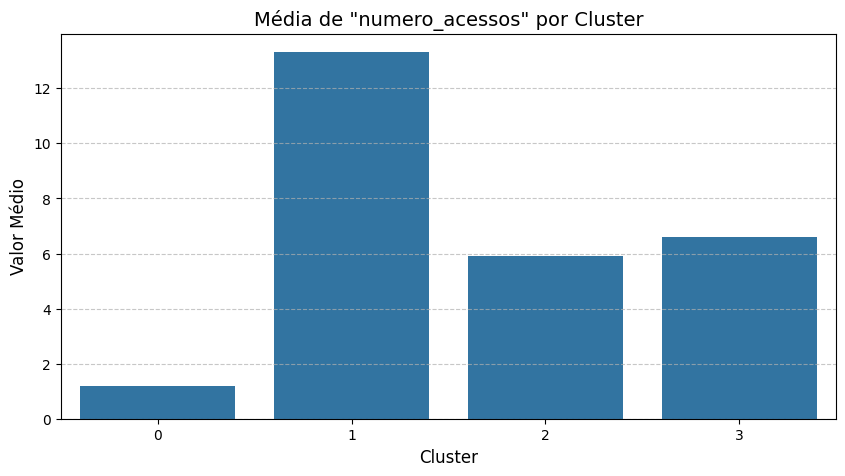

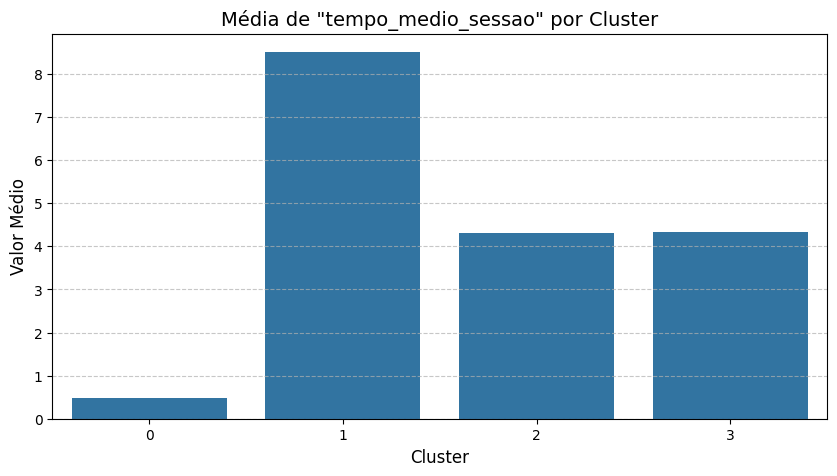

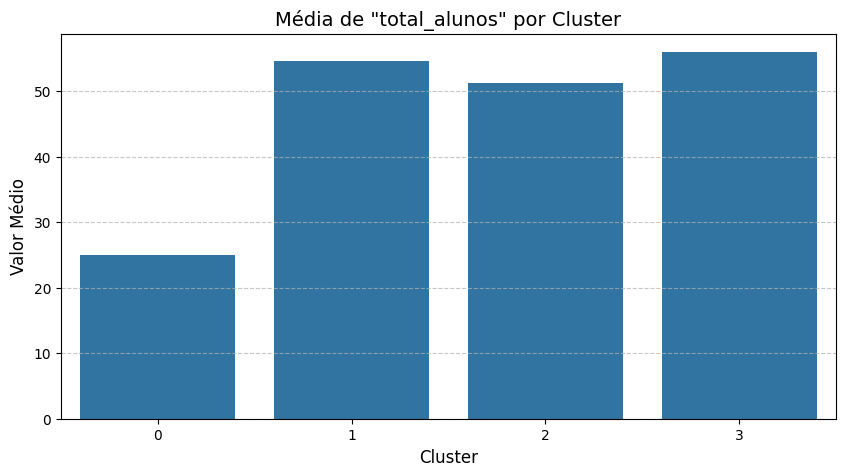

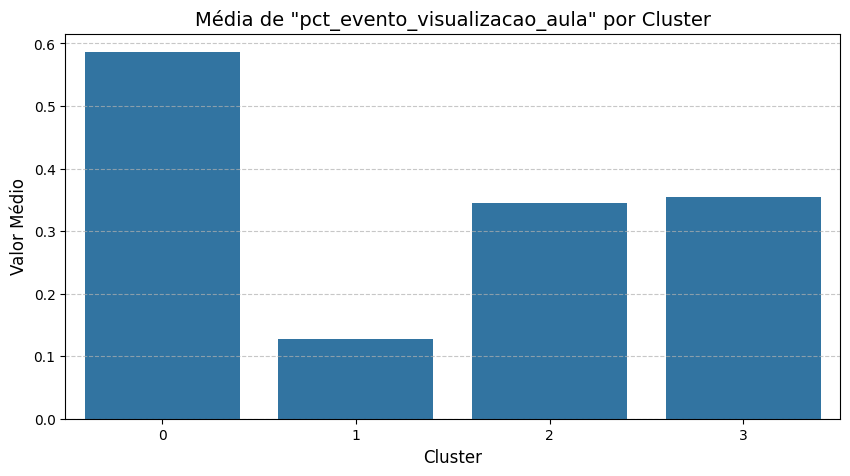

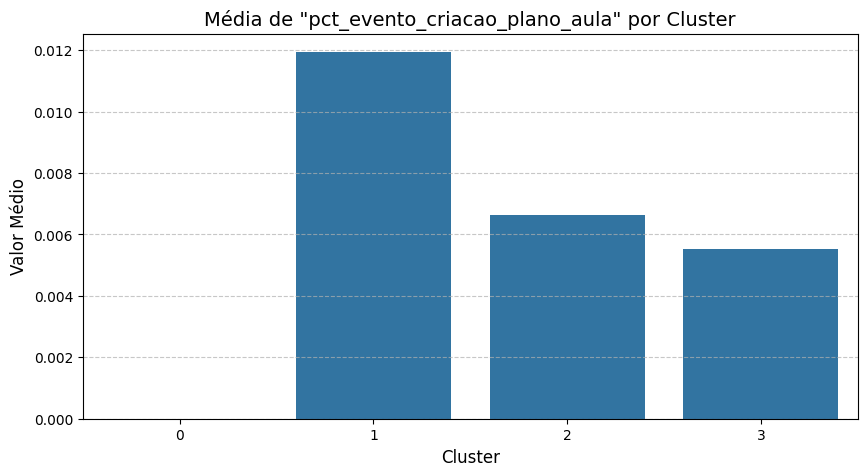

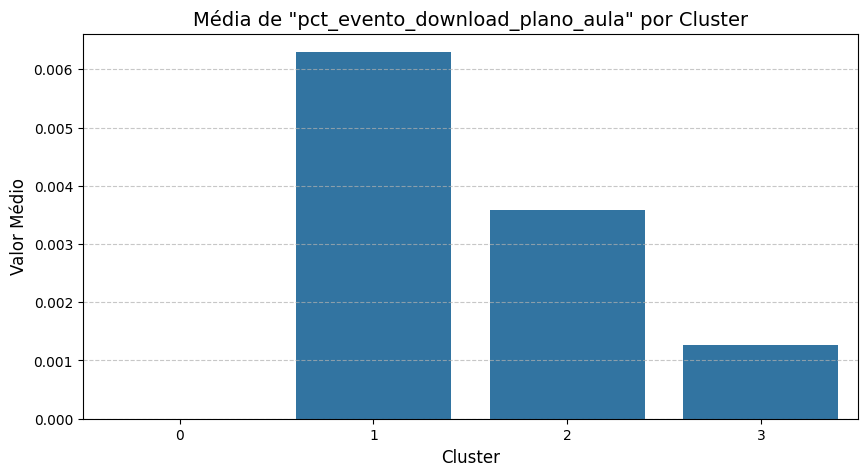

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Documentação:
# Esta célula visualiza os resultados da clusterização para facilitar a interpretação
# e a criação das personas para cada cluster.

# --- 1. PREPARAR DADOS PARA VISUALIZAÇÃO ---
# O dataframe 'analise_final' já contém as médias de cada cluster.
# Vamos adicionar o tamanho de cada cluster para enriquecer a análise.
cluster_sizes = df_processado['cluster'].value_counts().sort_index()
analise_final_com_tamanho = analise_final.copy()
analise_final_com_tamanho['tamanho_cluster'] = cluster_sizes

print("--- Tabela de Análise Final com Tamanho dos Clusters ---")
print(analise_final_com_tamanho)


# --- 2. GERAR GRÁFICOS DE BARRAS COMPARATIVOS ---
# Selecionamos as features mais importantes que definem os perfis
features_principais_para_plotar = [
    'numero_acessos',
    'tempo_medio_sessao',
    'total_alunos',
    'pct_evento_visualizacao_aula',
    'pct_evento_criacao_plano_aula',
    'pct_evento_download_plano_aula'
]

# Filtramos para garantir que as colunas existem
features_plot_existentes = [col for col in features_principais_para_plotar if col in analise_final_com_tamanho.columns]

print("\n--- Gráficos Comparativos dos Perfis de Cluster ---")

# Criamos um gráfico para cada feature
for feature in features_plot_existentes:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=analise_final_com_tamanho.index,
        y=analise_final_com_tamanho[feature]
    )
    plt.title(f'Média de "{feature}" por Cluster', fontsize=14)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Valor Médio', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

A História Contada pelos Dados: As 4 Personas de Professores
Conseguimos identificar 4 grupos com jornadas e necessidades muito diferentes dentro da plataforma.

Cluster 0: A Maioria "Perdida" ou Inativa (91.9% dos usuários)
O Perfil: Este é o grupo massivo de usuários que acessa a plataforma pouquíssimas vezes (média de ~1.2 acessos). Eles têm o menor tempo médio por sessão e, crucialmente, não realizam nenhuma ação de valor, como criar ou baixar planos de aula. Eles também tendem a ter turmas menores (total_alunos).

Insight Estratégico: Este grupo representa o maior desafio e a maior oportunidade de crescimento. O problema aqui é a ativação. Eles se cadastram, mas não encontram valor inicial para continuar. A plataforma precisa responder à pergunta: "Como podemos garantir que um novo usuário realize pelo menos uma ação de valor na sua primeira ou segunda sessão para que ele entenda o poder da ferramenta?". O onboarding (processo de boas-vindas) é crítico para este grupo.

Cluster 3: Os "Navegadores" ou Consumidores Passivos (7.4% dos usuários)
O Perfil: Um grupo de tamanho considerável que acessa a plataforma com uma frequência moderada (~5.5 vezes). No entanto, assim como o Cluster 0, eles quase não criam ou baixam planos de aula. Seu tempo médio de sessão é baixo, indicando visitas rápidas.

Insight Estratégico: Estes usuários estão "presos" no limbo do engajamento. Eles têm interesse suficiente para voltar à plataforma, mas não o suficiente para usar suas funcionalidades principais. Eles provavelmente "olham o cardápio, mas nunca pedem o prato principal". A estratégia aqui é a conversão para o engajamento. Eles precisam de "empurrões" (nudges), como tutoriais, pop-ups ou e-mails direcionados, mostrando os benefícios das ferramentas de planejamento que eles não estão usando.

Cluster 2: Os "Planejadores" — O Perfil de Sucesso (0.6% dos usuários)
O Perfil: Embora seja um grupo pequeno, este é o seu perfil de usuário ideal. Eles são os mais ativos em número de acessos (~15) e, mais importante, dominam absolutamente as ações de criar e baixar planos de aula. Uma parte significativa de tudo o que fazem na plataforma está ligada a essa funcionalidade. Eles também têm um tempo de sessão elevado e tendem a ter turmas maiores.

Insight Estratégico: Este grupo é sua "Estrela Guia". Toda a jornada do produto deve ser projetada para levar mais usuários a se comportarem como eles. É fundamental estudar tudo sobre este grupo: Quais conteúdos eles baixam? Em que momento do ano letivo? Como eles chegaram a este nível de uso? As respostas definirão o caminho para o sucesso de todos os outros usuários.

Cluster 1: Os "Pesquisadores" — O Nicho de Uso Profundo (0.05% dos usuários)
O Perfil: Um grupo minúsculo, mas fascinante. Sua característica mais marcante é o tempo médio de sessão, que é disparado o mais alto de todos. Eles não acessam com tanta frequência quanto os "Planejadores", mas quando o fazem, mergulham fundo. Eles também têm o maior número médio de alunos. Eles visualizam muitas aulas, mas não são tão focados em criar/baixar planos quanto o Cluster 2.

Insight Estratégico: Estes não são apenas usuários ativos, são "pesquisadores" ou "consumidores profundos". Eles podem estar usando a plataforma para pesquisa, estudo aprofundado de materiais ou para um propósito muito específico que não é o planejamento. Vale a pena investigar este nicho. Por que as sessões deles são tão longas? Eles podem estar revelando um caso de uso secundário e valioso da sua plataforma.

Resumo dos Insights e Próximos Passos
O Engajamento Real está no Planejamento: Sua análise prova que as ações de criar e baixar planos de aula são o principal diferencial entre um usuário casual e um usuário de alto valor (Cluster 2).

O Elo Perdido: O maior desafio é mover os "Navegadores" (Cluster 3) para que se tornem "Planejadores" (Cluster 2). Eles já estão na plataforma; só precisam descobrir o valor das ferramentas principais.

O Contexto Importa: Usuários mais engajados (total_alunos mais alto) parecem ser os que mais se beneficiam. Isso pode indicar uma oportunidade de focar a comunicação em professores de escolas maiores ou com mais turmas.